# Tutorial 2 - synapses
This tutorial explains how to add synapses to connect the neuron populations we talked about in the previous tutorial into a balanced random network model.

## Install PyGeNN wheel from Google Drive
Download wheel file

In [ ]:
!gdown 1-4H8-H48tEnb-9I9EtLyNfPdLQLe2JRV

and then install PyGeNN from wheel file

In [ ]:
!pip install pygenn-4.8.0-cp38-cp38-linux_x86_64.whl

Set environment variable to allow GeNN to find CUDA

In [ ]:
%env CUDA_PATH=/usr/local/cuda

env: CUDA_PATH=/usr/local/cuda


Import numpy, matplotlib and the main `GeNNModel` class from PyGeNN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from pygenn.genn_model import GeNNModel, init_connectivity, init_var

## Build model
Create a new model called "tutorial2" with floating point precision and set the simulation timestep to 1ms

In [ ]:
model = GeNNModel("float", "tutorial2")
model.dT = 1.0

For this tutorial were going to use Leaky-Integrate-and-Fire neurons which have the following dynamics:

\begin{align}
    \tau_{\text{m}} \frac{dV_{i}}{dt} = & (V_{\text{rest}} - V_{i}) + R_{\text{m}}I_{i}.
\end{align}

We configure these using the parameters from (Vogels & Abbott, 2005 [link text](https://doi.org/10.1523/JNEUROSCI.3508-05.2005)). Note that the resting voltage is **higher** than the reset to provide a constant current input **TODO** get rid of this

In [ ]:
lif_params = {"C": 1.0, "TauM": 20.0, "Vrest": -49.0, "Vreset": -60.0,
              "Vthresh": -50.0, "Ioffset": 0.0, "TauRefrac": 5.0}

So that the network starts in a non-pathological state, we want to randomly initialise the neuron's membrane potentials so that they are between their threshold and resting potentials. GeNN provides [various](https://genn-team.github.io/genn/documentation/4/html/d4/dc6/sectVariableInitialisation.html) initialisation "snippets" which can be used to parallelise variable initialisation but, here we are going to use `Uniform` to sample values from a uniform distribution.

In [ ]:
lif_init = {"V": init_var("Uniform", {"min": -60.0, "max": -50.0}),
            "RefracTime": 0.0}

For this tutorial we create an excitary and inhibitory population of these neurons and we enable spike recording for both

In [ ]:
exc_pop = model.add_neuron_population("E", 3200, "LIF", lif_params, lif_init)
inh_pop = model.add_neuron_population("I", 800, "LIF", lif_params, lif_init)

exc_pop.spike_recording_enabled = True
inh_pop.spike_recording_enabled = True

So this network sits in a asynchronous irregular state, we initialise the inhibitory weights as follows:

In [ ]:
exc_synapse_init = {"g": 0.0008}
inh_synapse_init = {"g": -0.0102}

We are going to use an exponential synapse model where a single time constant $\tau_{\text{syn}}$ to define it's dynamics:
\begin{align}
    \tau_{\text{syn}} \frac{dI_{\text{syn}_{i}}}{dt} = & -I_{\text{syn}_{i}} + \sum_{j=0}^{n} w_{ij} \sum_{t_{j}}  \delta(t - t_{j}).
\end{align}
To approximate biolological AMPA and GABA receptors, we pick different time constants for excitatory and inhibitory synapses.

In [ ]:
exc_post_syn_params = {"tau": 5.0}
inh_post_syn_params = {"tau": 10.0}

We want to connect these with a fixed probability of 0.1

In [ ]:
fixed_prob = {"prob": 0.1}

Now we have defined the synaptic weights (in GeNN, this is the responsibility of the **weight update model**), the synapse dynamics (in GeNN this is the responsibility of the **postsynaptic model**) and the connectivity parameters we can add the synapse populations to the model.
Each of these synapse populations all configured with:
*   `SPARSE_GLOBALG` connectivity meaning that they are connected with a sparse weight matrix where each weight is the same (see [documentation](https://genn-team.github.io/genn/documentation/4/html/d5/d39/subsect34.html)).
*   `0` delay
*   The built in `StaticPulse` **weight update model** which is used for spiking synapses without any sort of learning. This has no parameters and a single state variable `g` representing its synaptic weights which we initialise using our arrays of pre-trained weights.
*   The build in `ExpCurr` **postsynaptic model** which implements the exponential synapses described previously
*   The sparse connectivity is configured using the built in `FixedProbability` model described previosuly


In [ ]:
model.add_synapse_population("EE", "SPARSE_GLOBALG", 0,
    exc_pop, exc_pop,
    "StaticPulse", {}, exc_synapse_init, {}, {},
    "ExpCurr", exc_post_syn_params, {},
    init_connectivity("FixedProbabilityNoAutapse", fixed_prob))

model.add_synapse_population("EI", "SPARSE_GLOBALG", 0,
    exc_pop, inh_pop,
    "StaticPulse", {}, exc_synapse_init, {}, {},
    "ExpCurr", exc_post_syn_params, {},
    init_connectivity("FixedProbability", fixed_prob))

model.add_synapse_population("II", "SPARSE_GLOBALG", 0,
    inh_pop, inh_pop,
    "StaticPulse", {}, inh_synapse_init, {}, {},
    "ExpCurr", inh_post_syn_params, {},
    init_connectivity("FixedProbabilityNoAutapse", fixed_prob))

model.add_synapse_population("IE", "SPARSE_GLOBALG", 0,
    inh_pop, exc_pop,
    "StaticPulse", {}, inh_synapse_init, {}, {},
    "ExpCurr", inh_post_syn_params, {},
    init_connectivity("FixedProbability", fixed_prob));

Run code generator to generate simulation code for model and load it into PyGeNN. Allocate a spike recording buffer large enough to store the spikes emitted throughout our entire 1 second simulation

In [ ]:
model.build()
model.load(num_recording_timesteps=1000)

## Simulate model


Simulate the model for 1000 timesteps

In [ ]:
while model.timestep < 1000:
    model.step_time()

Copy the recorded spike data back from the GPU and extract the spike times and IDs

In [ ]:
model.pull_recording_buffers_from_device()

exc_spike_times, exc_spike_ids = exc_pop.spike_recording_data
inh_spike_times, inh_spike_ids = inh_pop.spike_recording_data

Plot spikes and rates

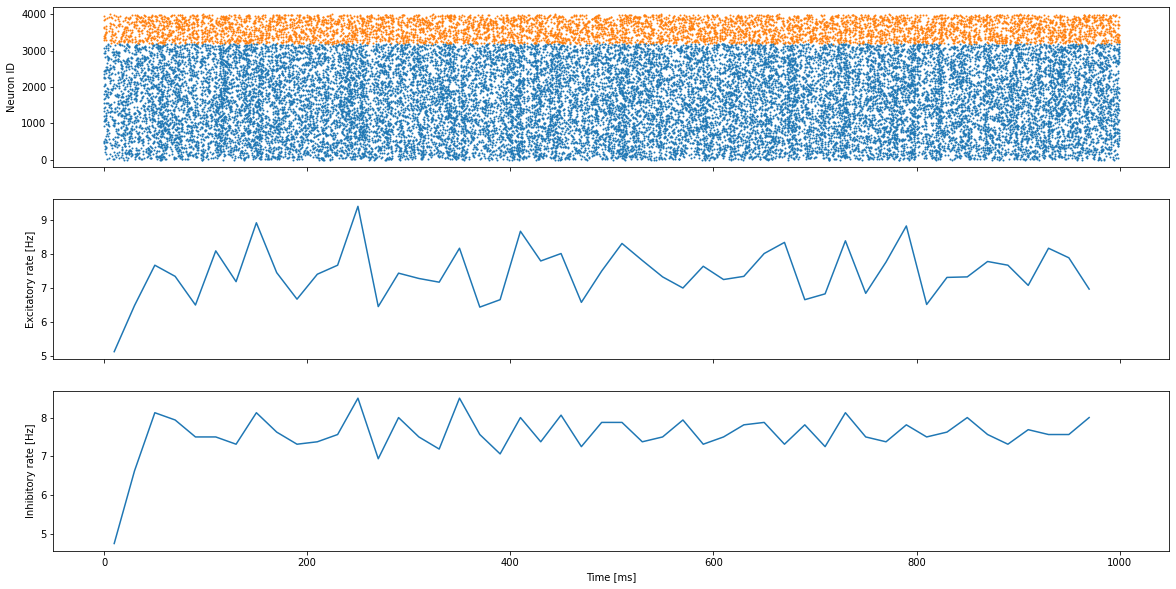

In [ ]:
fig, axes = plt.subplots(3, sharex=True, figsize=(20, 10))

# Define some bins to calculate spike rates
bin_size = 20.0
rate_bins = np.arange(0, 1000.0, bin_size)
rate_bin_centres = rate_bins[:-1] + (bin_size / 2.0)

# Plot excitatory and inhibitory spikes on first axis
axes[0].scatter(exc_spike_times, exc_spike_ids, s=1)
axes[0].scatter(inh_spike_times, inh_spike_ids + 3200, s=1)

# Plot excitatory rates on second axis
exc_rate = np.histogram(exc_spike_times, bins=rate_bins)[0]
axes[1].plot(rate_bin_centres, exc_rate * (1000.0 / bin_size) * (1.0 / 3200.0))

# Plot inhibitory rates on third axis
inh_rate = np.histogram(inh_spike_times, bins=rate_bins)[0]
axes[2].plot(rate_bin_centres, inh_rate * (1000.0 / bin_size) * (1.0 / 800.0))

# Label axes
axes[0].set_ylabel("Neuron ID")
axes[1].set_ylabel("Excitatory rate [Hz]")
axes[2].set_ylabel("Inhibitory rate [Hz]")
axes[2].set_xlabel("Time [ms]");